# Data Transformations: Mathematical Foundations and Practical Guide

## 🎯 Why Transform Data? The Fundamental Motivation

Data transformations are like **changing the language** in which we describe our data. Sometimes the original "language" makes patterns hard to see, relationships non-linear, or statistical assumptions violated. Transformations help us:

1. **Normalize distributions** (make skewed data more symmetric)
2. **Stabilize variance** (make spread consistent across values)
3. **Linearize relationships** (turn curves into straight lines)
4. **Meet statistical assumptions** (normality, homoscedasticity)
5. **Improve interpretability** (meaningful scales)

**Think of it like this**: If you're trying to measure exponential growth, plotting on a logarithmic scale reveals the underlying linear pattern that was hidden in the original scale.

---

## 📊 The Transformation Landscape

### Basic Categories

| Type | Purpose | Examples | When to Use |
|------|---------|----------|-------------|
| **Power** | Handle skewness | Square root, cube root | Right-skewed data |
| **Logarithmic** | Exponential relationships | Natural log, log10 | Multiplicative processes |
| **Box-Cox** | Normalize distributions | Generalized power | Find optimal transformation |
| **Yeo-Johnson** | Handle zeros/negatives | Extended Box-Cox | Mixed sign data |
| **Inverse** | Extreme skewness | 1/x, 1/x² | Heavy right tails |
| **Trigonometric** | Periodic patterns | sin, cos, arcsin | Circular/bounded data |

---

## 🧮 Power Transformations: The Foundation

### Mathematical Framework

Power transformations form the backbone of data transformation theory:

$$T(x) = x^{\lambda}$$

where $\lambda$ is the **transformation parameter**.

### Special Cases with Intuition

#### 1. Square Root Transformation ($\lambda = 0.5$)

**Formula**: $T(x) = \sqrt{x}$

**When to use**: Moderately right-skewed data, count data following Poisson distribution.

**Intuition**: "Compresses" large values more than small values, reducing right skew.

**Effect on variance**: If $\text{Var}(X) \propto \mu$, then $\text{Var}(\sqrt{X}) \approx \text{constant}$

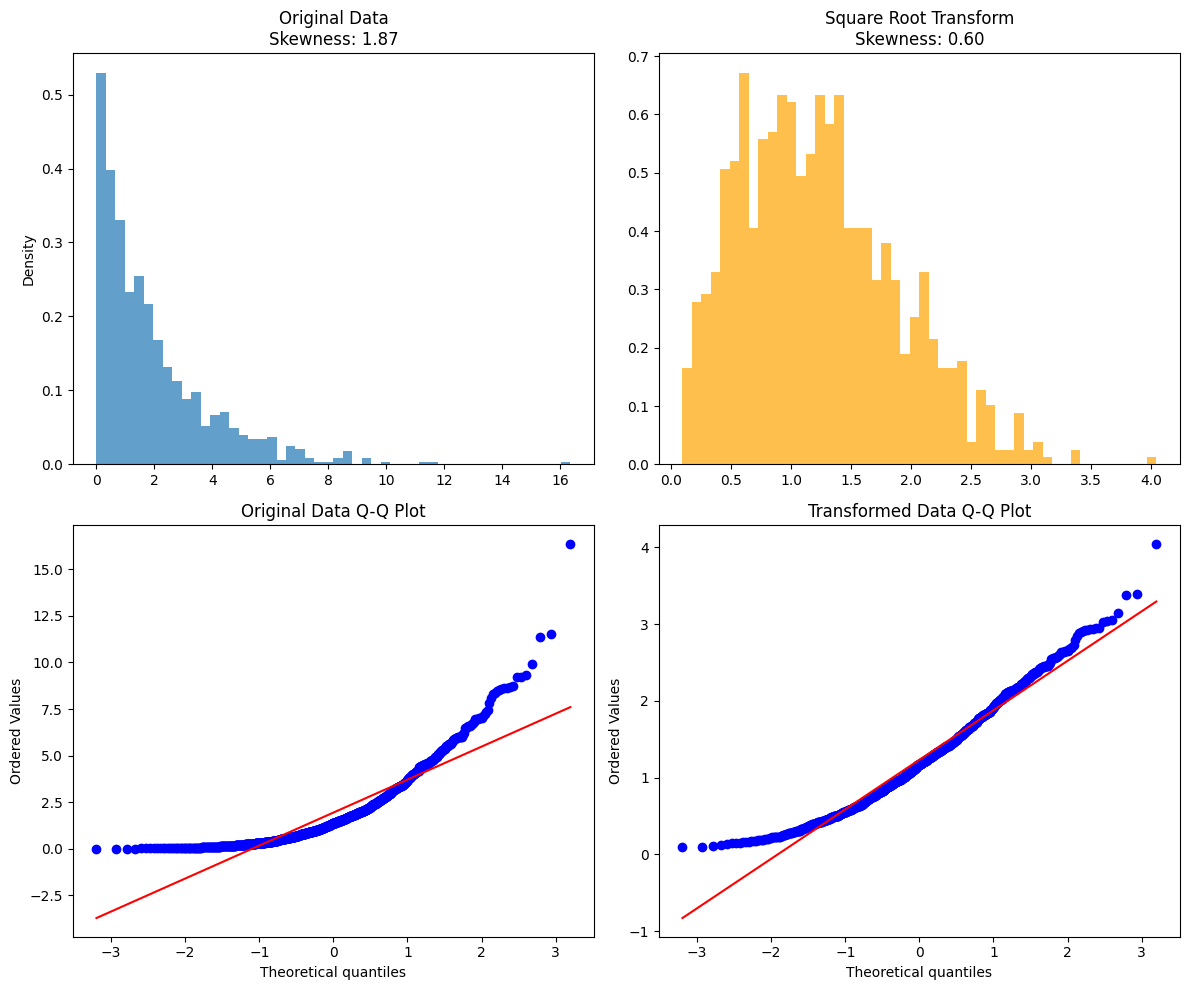

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def demonstrate_sqrt_transformation():
    """Show effect of square root transformation"""
    # Generate right-skewed data (exponential)
    np.random.seed(42)
    data = np.random.exponential(scale=2, size=1000)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original data
    axes[0,0].hist(data, bins=50, alpha=0.7, density=True)
    axes[0,0].set_title(f'Original Data\nSkewness: {stats.skew(data):.2f}')
    axes[0,0].set_ylabel('Density')
    
    # Square root transformed
    sqrt_data = np.sqrt(data)
    axes[0,1].hist(sqrt_data, bins=50, alpha=0.7, density=True, color='orange')
    axes[0,1].set_title(f'Square Root Transform\nSkewness: {stats.skew(sqrt_data):.2f}')
    
    # Q-Q plots for normality check
    stats.probplot(data, dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Original Data Q-Q Plot')
    
    stats.probplot(sqrt_data, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Transformed Data Q-Q Plot')
    
    plt.tight_layout()
    plt.show()

demonstrate_sqrt_transformation()

#### 2. Logarithmic Transformation ($\lambda \to 0$)

**Formula**: $T(x) = \log(x)$ (as $\lambda \to 0$ in Box-Cox framework)

**When to use**: 
- Highly right-skewed data
- Multiplicative processes (economic growth, population growth)
- Data spanning several orders of magnitude

**Mathematical properties**:
- $\log(ab) = \log(a) + \log(b)$ (turns multiplication into addition)
- $\log(a^b) = b\log(a)$ (turns exponentiation into multiplication)

**Variance stabilization**: If $\text{Var}(X) \propto \mu^2$, then $\text{Var}(\log X) \approx \text{constant}$

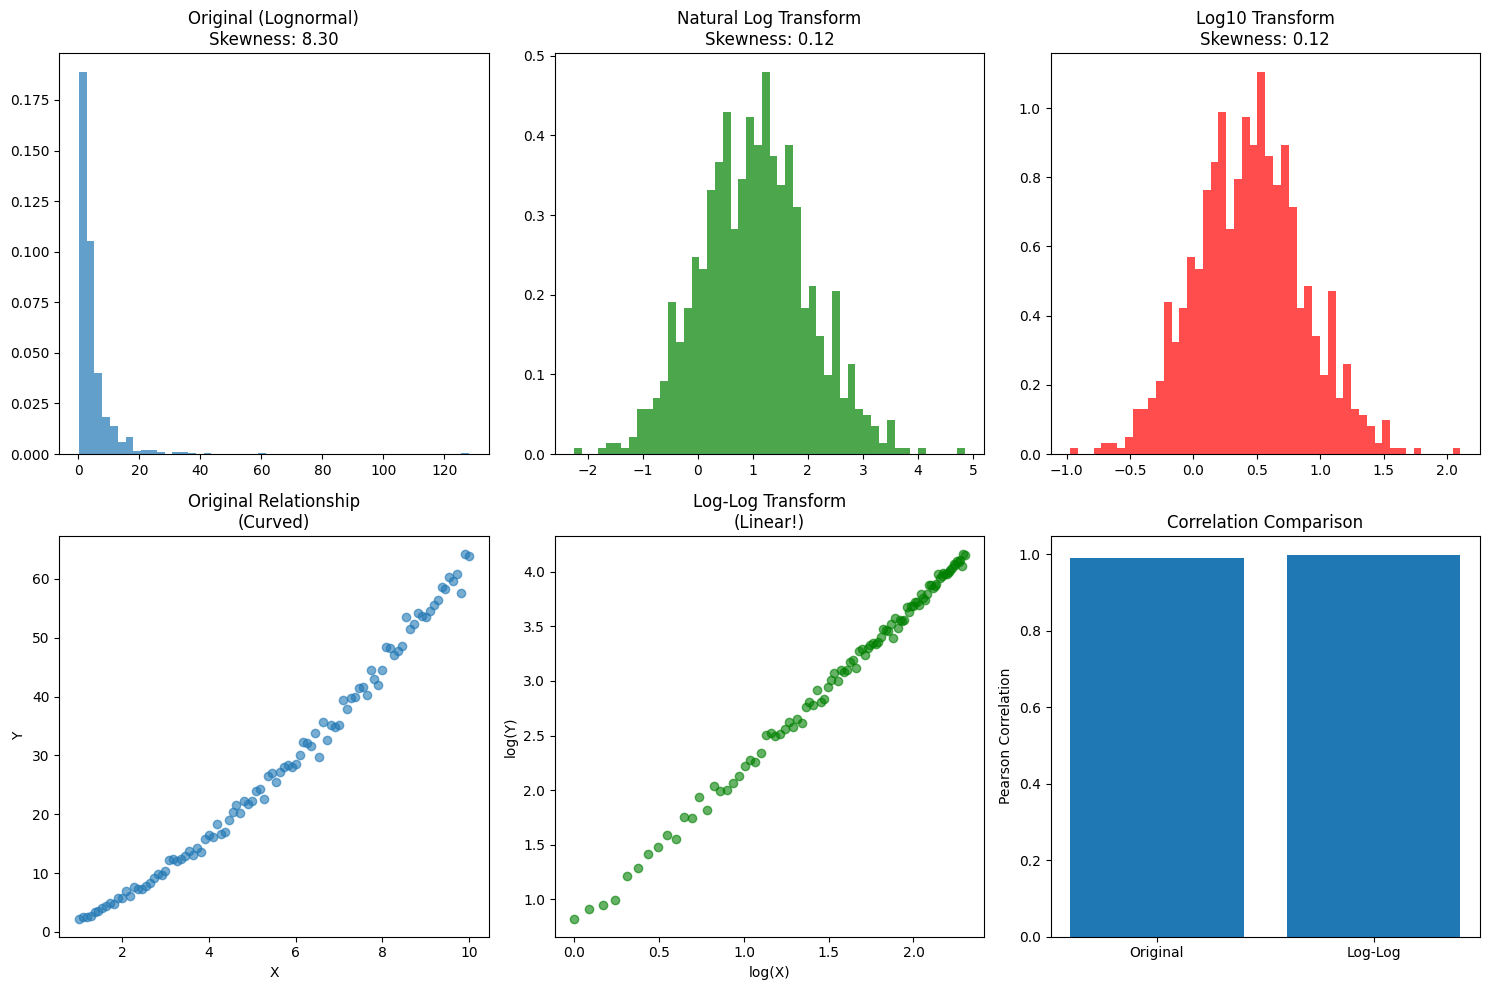

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
def demonstrate_log_transformation():
    """Show logarithmic transformation effects"""
    # Generate lognormal data
    np.random.seed(42)
    data = np.random.lognormal(mean=1, sigma=1, size=1000)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original data
    axes[0,0].hist(data, bins=50, alpha=0.7, density=True)
    axes[0,0].set_title(f'Original (Lognormal)\nSkewness: {stats.skew(data):.2f}')
    
    # Natural log transformation
    log_data = np.log(data)
    axes[0,1].hist(log_data, bins=50, alpha=0.7, density=True, color='green')
    axes[0,1].set_title(f'Natural Log Transform\nSkewness: {stats.skew(log_data):.2f}')
    
    # Log10 transformation
    log10_data = np.log10(data)
    axes[0,2].hist(log10_data, bins=50, alpha=0.7, density=True, color='red')
    axes[0,2].set_title(f'Log10 Transform\nSkewness: {stats.skew(log10_data):.2f}')
    
    # Show relationship preservation
    x = np.linspace(1, 10, 100)
    y = 2 * x**1.5 + np.random.normal(0, x*0.2, len(x))
    
    axes[1,0].scatter(x, y, alpha=0.6)
    axes[1,0].set_title('Original Relationship\n(Curved)')
    axes[1,0].set_xlabel('X')
    axes[1,0].set_ylabel('Y')
    
    # Log-log plot linearizes power relationships
    axes[1,1].scatter(np.log(x), np.log(y), alpha=0.6, color='green')
    axes[1,1].set_title('Log-Log Transform\n(Linear!)')
    axes[1,1].set_xlabel('log(X)')
    axes[1,1].set_ylabel('log(Y)')
    
    # Correlation comparison
    corr_orig = np.corrcoef(x, y)[0,1]
    corr_log = np.corrcoef(np.log(x), np.log(y))[0,1]
    axes[1,2].bar(['Original', 'Log-Log'], [corr_orig, corr_log])
    axes[1,2].set_title('Correlation Comparison')
    axes[1,2].set_ylabel('Pearson Correlation')
    
    plt.tight_layout()
    plt.show()

demonstrate_log_transformation()

# 🎯 Box–Cox Transformation and MLE Derivation

### 1. The Goal

We want to find the power parameter $\lambda$ that makes the transformed data:

$$
y_i = T(x_i;\lambda) =
\begin{cases}
\frac{x_i^\lambda - 1}{\lambda}, & \lambda \neq 0 \\
\log(x_i), & \lambda = 0
\end{cases}
$$

as close to **normal** as possible.

So we assume:

$$
y_i \sim \mathcal{N}(\mu, \sigma^2) \quad \text{independently}.
$$

---

### 2. The Likelihood Function (Normal Assumption)

For a normal sample $y_1,\dots,y_n$:

$$
L(\mu, \sigma^2 \mid y) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} 
\exp\left(-\frac{(y_i - \mu)^2}{2\sigma^2}\right).
$$

Taking logs:

$$
\ell(\mu, \sigma^2 \mid y) = -\frac{n}{2}\log(2\pi) - \frac{n}{2}\log(\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^n (y_i - \mu)^2.
$$

So far this is just the usual normal log-likelihood.

---

### 3. Adjust for the Transformation (Jacobian)

But: we didn’t observe $y_i$. We observed $x_i$, and applied a transformation $T$.

By the **change-of-variable formula**, the density must be corrected with the Jacobian:

$$
f_X(x) = f_Y(T(x)) \cdot \left|\frac{dT}{dx}\right|.
$$

Taking logs, this adds:

$$
\sum_{i=1}^n \log \left|\frac{dT(x_i)}{dx_i}\right|
$$

to the likelihood.

* For Box–Cox:

  $$
  \frac{dT(x)}{dx} = x^{\lambda-1}.
  $$

So the correction term is:

$$
(\lambda - 1) \sum_{i=1}^n \log(x_i).
$$

---

### 4. Plugging Everything Together

Now the log-likelihood for $\lambda$ becomes:

$$
\ell(\mu, \sigma^2, \lambda) =
-\frac{n}{2}\log(2\pi) 
- \frac{n}{2}\log(\sigma^2) 
- \frac{1}{2\sigma^2}\sum_{i=1}^n (y_i - \mu)^2
+ (\lambda - 1)\sum_{i=1}^n \log(x_i).
$$

---

### 5. Eliminate $\mu$ and $\sigma^2$

* The MLE of $\mu$ is just the sample mean of transformed data:

  $$
  \hat{\mu} = \bar{y}.
  $$

* The MLE of $\sigma^2$ is the sample variance:

  $$
  \hat{\sigma}^2 = \frac{1}{n}\sum_{i=1}^n (y_i - \bar{y})^2.
  $$

Substituting these back into $\ell$, we get the profile log-likelihood for $\lambda$:

$$
\ell(\lambda) =
-\frac{n}{2}\log(2\pi) 
- \frac{n}{2}\log(\hat{\sigma}^2) 
- \frac{n}{2} 
+ (\lambda - 1)\sum_{i=1}^n \log(x_i).
$$

This is the expression you had, just rearranged.

---

### 6. Intuition

* The **first part** (normal likelihood of transformed data) says: *“How well do the transformed values fit a Gaussian?”*
* The **second part** (Jacobian term) says: *“Don’t forget that squeezing/stretching data changes its probability mass.”*
* Together: find $\lambda$ that maximizes how Gaussian the transformed values look.

---

### 7. Algorithm in Words

1. Choose a candidate $\lambda$.
2. Transform $x_i$ using Box–Cox.
3. Compute the variance of transformed data.
4. Evaluate log-likelihood (with Jacobian).
5. Repeat for many $\lambda$, pick the one with max log-likelihood.

---

### 8. Python Illustration

```python
import numpy as np
from scipy import stats

X = np.array([2, 3, 5, 7, 10, 15])  # toy data

lambdas = np.linspace(-2, 2, 41)
lls = []

for lam in lambdas:
    # Apply Box-Cox
    if lam != 0:
        Y = (X**lam - 1) / lam
    else:
        Y = np.log(X)
    
    # variance term
    sigma2 = np.var(Y, ddof=0)
    
    # log-likelihood (up to constant)
    ll = -len(X)/2 * np.log(sigma2) + (lam - 1)*np.sum(np.log(X))
    lls.append(ll)

best_lambda = lambdas[np.argmax(lls)]
print("Best λ:", best_lambda)
```

Optimal λ: 0.295


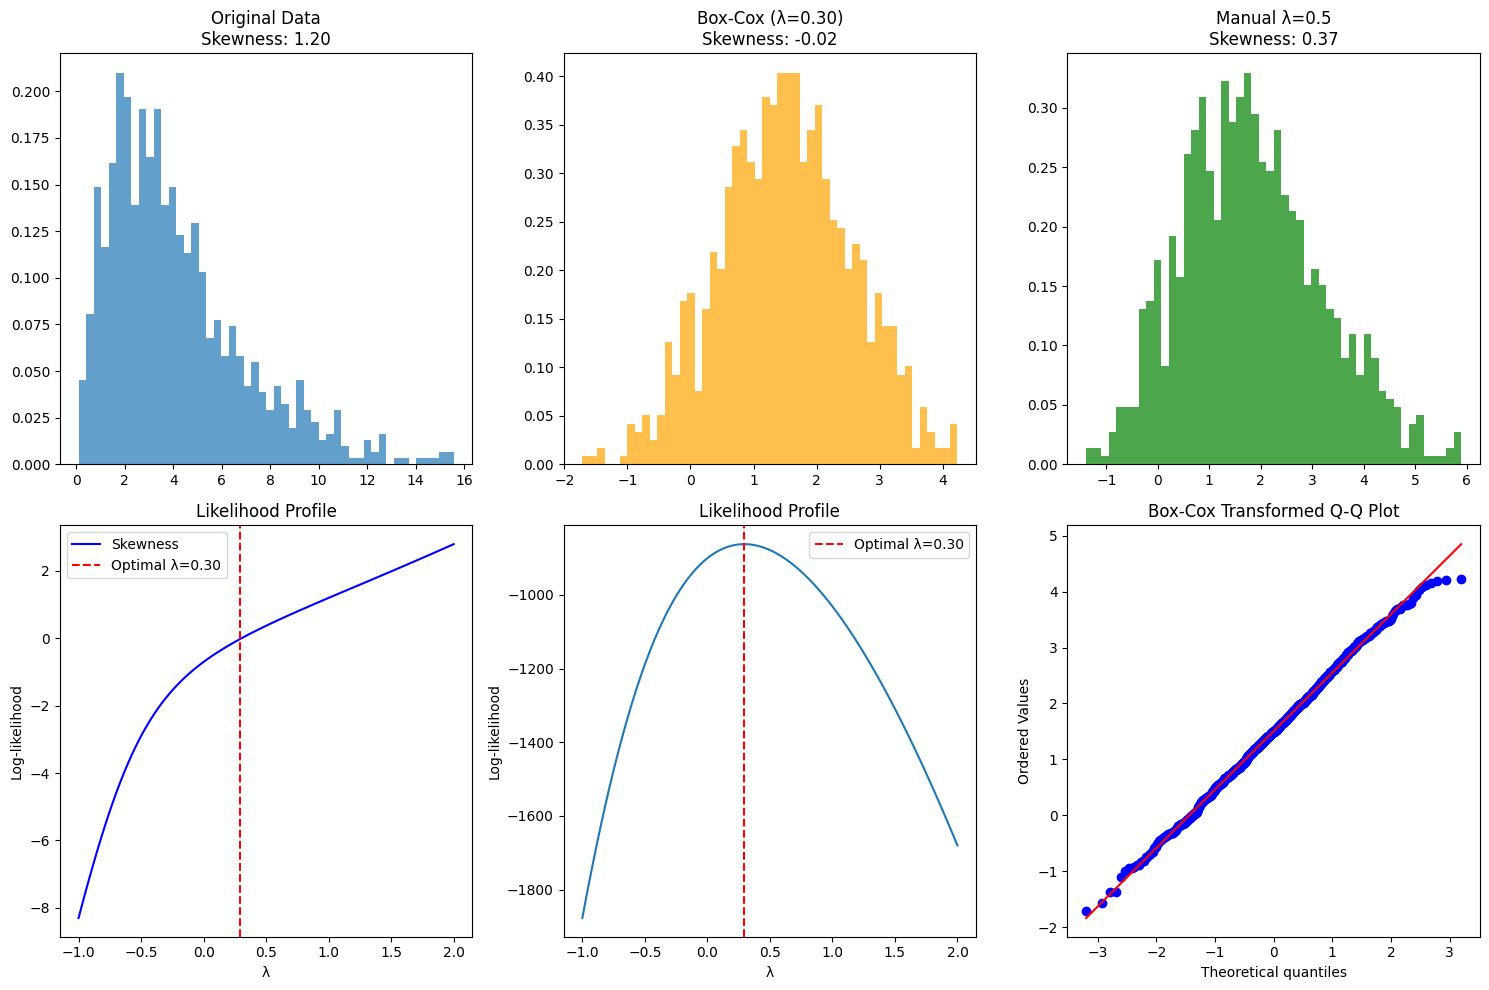

In [4]:
from scipy.stats import boxcox
from scipy.optimize import minimize_scalar
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def boxcox_transformation_demo():
    """Comprehensive Box-Cox demonstration"""
    # Generate right-skewed data
    np.random.seed(42)
    data = np.random.gamma(shape=2, scale=2, size=1000)
    
    # Find optimal lambda
    transformed_data, optimal_lambda = boxcox(data)
    
    print(f"Optimal λ: {optimal_lambda:.3f}")
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original data
    axes[0,0].hist(data, bins=50, alpha=0.7, density=True)
    axes[0,0].set_title(f'Original Data\nSkewness: {stats.skew(data):.2f}')
    
    # Box-Cox transformed
    axes[0,1].hist(transformed_data, bins=50, alpha=0.7, density=True, color='orange')
    axes[0,1].set_title(f'Box-Cox (λ={optimal_lambda:.2f})\nSkewness: {stats.skew(transformed_data):.2f}')
    
    # Compare with other lambdas
    lambda_test = 0.5  # Square root
    manual_transform = (data**lambda_test - 1) / lambda_test
    axes[0,2].hist(manual_transform, bins=50, alpha=0.7, density=True, color='green')
    axes[0,2].set_title(f'Manual λ=0.5\nSkewness: {stats.skew(manual_transform):.2f}')
    
    # Likelihood profile
    lambdas = np.linspace(-1, 2, 100)
    likelihoods = []
    sknewesses = []
    
    for lam in lambdas:
        if lam != 0:
            temp_data = (data**lam - 1) / lam
        else:
            temp_data = np.log(data)
        
        # Log-likelihood (simplified)
        ll = -0.5 * len(data) * np.log(np.var(temp_data)) + (lam - 1) * np.sum(np.log(data))
        likelihoods.append(ll)
        sknewesses.append((stats.skew(temp_data)))

    
    axes[1,0].plot(lambdas, sknewesses, label='Skewness', color='blue')
    axes[1,0].axvline(optimal_lambda, color='red', linestyle='--', 
                     label=f'Optimal λ={optimal_lambda:.2f}')
    axes[1,0].set_xlabel('λ')
    axes[1,0].set_ylabel('Log-likelihood')
    axes[1,0].set_title('Likelihood Profile')
    axes[1,0].legend()
    
    # Q-Q plots
    axes[1,1].plot(lambdas, likelihoods)
    axes[1,1].axvline(optimal_lambda, color='red', linestyle='--', 
                     label=f'Optimal λ={optimal_lambda:.2f}')
    axes[1,1].set_xlabel('λ')
    axes[1,1].set_ylabel('Log-likelihood')
    axes[1,1].set_title('Likelihood Profile')
    axes[1,1].legend()
    
    stats.probplot(transformed_data, dist="norm", plot=axes[1,2])
    axes[1,2].set_title('Box-Cox Transformed Q-Q Plot')
    
    plt.tight_layout()
    plt.show()

boxcox_transformation_demo()

### Interpreting $\lambda$ Values

| $\lambda$ | Transformation | Interpretation | Use Case |
|-----------|----------------|----------------|----------|
| 2 | $x^2$ | Emphasizes large values | Left-skewed data |
| 1 | $x$ (no change) | Linear scale | Already normal |
| 0.5 | $\sqrt{x}$ | Moderate compression | Poisson-like data |
| 0 | $\log(x)$ | Strong compression | Lognormal data |
| -0.5 | $-1/\sqrt{x}$ | Inverse + order preservation | Heavy right tails |
| -1 | $-1/x$ | Full inversion | Extreme right skew |

---

## 🔄 Yeo-Johnson Transformation: Handling All Real Numbers

### The Problem with Box-Cox

Box-Cox requires $x > 0$. What about negative values or zeros?

### The Yeo-Johnson Solution

$$T(x) = \begin{cases}
\frac{(x+1)^{\lambda} - 1}{\lambda} & \text{if } \lambda \neq 0 \text{ and } x \geq 0 \\
\log(x+1) & \text{if } \lambda = 0 \text{ and } x \geq 0 \\
-\frac{(-x+1)^{2-\lambda} - 1}{2-\lambda} & \text{if } \lambda \neq 2 \text{ and } x < 0 \\
-\log(-x+1) & \text{if } \lambda = 2 \text{ and } x < 0
\end{cases}$$

**Key insights**:
- **Positive values**: Similar to Box-Cox (with shift)
- **Negative values**: Symmetric treatment
- **Continuity**: Smooth across zero
- **Parameter space**: $\lambda$ can be any real number

Optimal λ: 0.764


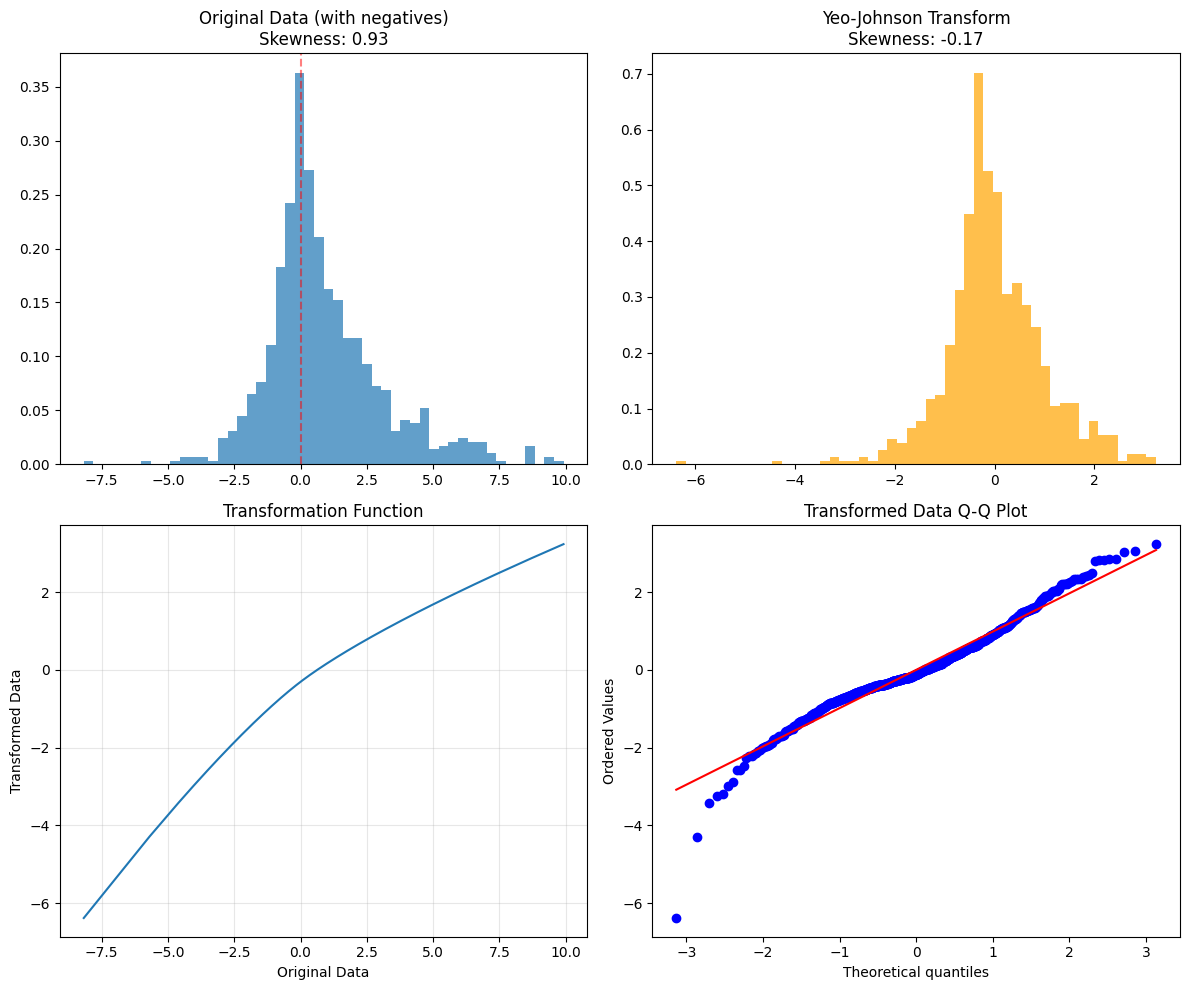

In [9]:
from sklearn.preprocessing import PowerTransformer

def yeo_johnson_demo():
    """Demonstrate Yeo-Johnson transformation"""
    # Generate data with negative values
    np.random.seed(42)
    positive_part = np.random.exponential(scale=2, size=500)
    negative_part = -np.random.exponential(scale=1, size=300)
    data = np.concatenate([positive_part, negative_part])
    
    # Apply Yeo-Johnson transformation
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    transformed_data = pt.fit_transform(data.reshape(-1, 1)).flatten()
    
    print(f"Optimal λ: {pt.lambdas_[0]:.3f}")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original data
    axes[0,0].hist(data, bins=50, alpha=0.7, density=True)
    axes[0,0].set_title(f'Original Data (with negatives)\nSkewness: {stats.skew(data):.2f}')
    axes[0,0].axvline(0, color='red', linestyle='--', alpha=0.5)
    
    # Transformed data
    axes[0,1].hist(transformed_data, bins=50, alpha=0.7, density=True, color='orange')
    axes[0,1].set_title(f'Yeo-Johnson Transform\nSkewness: {stats.skew(transformed_data):.2f}')
    
    # Scatter plot showing transformation
    sorted_indices = np.argsort(data)
    axes[1,0].plot(data[sorted_indices], transformed_data[sorted_indices])
    axes[1,0].set_xlabel('Original Data')
    axes[1,0].set_ylabel('Transformed Data')
    axes[1,0].set_title('Transformation Function')
    axes[1,0].grid(True, alpha=0.3)
    
    # Q-Q plot
    stats.probplot(transformed_data, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Transformed Data Q-Q Plot')
    
    plt.tight_layout()
    plt.show()

yeo_johnson_demo()

---

## 📐 Specialized Transformations

### 1. Angular/Arcsin Transformation

**Formula**: $T(x) = \arcsin(\sqrt{x})$ for $x \in [0,1]$

**Purpose**: Variance stabilization for proportions/percentages.

**Theory**: If $X \sim \text{Beta}(a,b)$, then $\arcsin(\sqrt{X})$ has approximately constant variance.

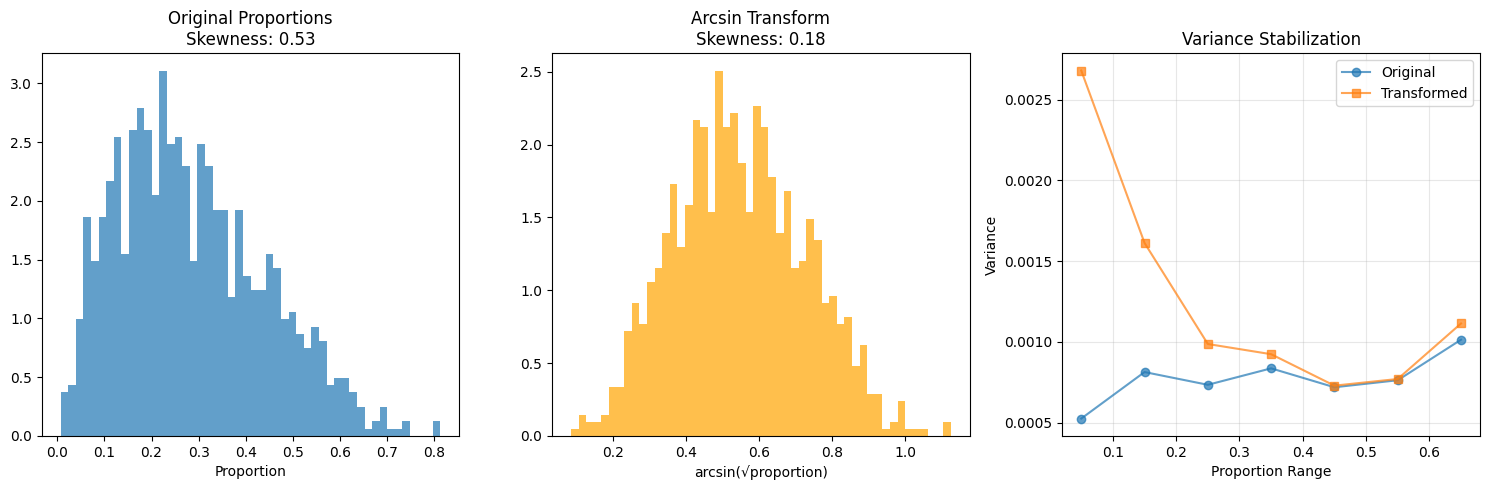

In [5]:
def arcsin_transformation():
    """Demonstrate arcsin transformation for proportions"""
    # Generate proportion data
    np.random.seed(42)
    proportions = np.random.beta(a=2, b=5, size=1000)  # Skewed proportions
    
    # Apply arcsin transformation
    transformed = np.arcsin(np.sqrt(proportions))
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original
    axes[0].hist(proportions, bins=50, alpha=0.7, density=True)
    axes[0].set_title(f'Original Proportions\nSkewness: {stats.skew(proportions):.2f}')
    axes[0].set_xlabel('Proportion')
    
    # Transformed
    axes[1].hist(transformed, bins=50, alpha=0.7, density=True, color='orange')
    axes[1].set_title(f'Arcsin Transform\nSkewness: {stats.skew(transformed):.2f}')
    axes[1].set_xlabel('arcsin(√proportion)')
    
    # Variance across range
    bins = np.linspace(0, 1, 11)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    original_vars = []
    transformed_vars = []
    
    for i in range(len(bins)-1):
        mask = (proportions >= bins[i]) & (proportions < bins[i+1])
        if np.sum(mask) > 10:  # Enough data points
            original_vars.append(np.var(proportions[mask]))
            transformed_vars.append(np.var(transformed[mask]))
        else:
            original_vars.append(np.nan)
            transformed_vars.append(np.nan)
    
    axes[2].plot(bin_centers, original_vars, 'o-', label='Original', alpha=0.7)
    axes[2].plot(bin_centers, transformed_vars, 's-', label='Transformed', alpha=0.7)
    axes[2].set_xlabel('Proportion Range')
    axes[2].set_ylabel('Variance')
    axes[2].set_title('Variance Stabilization')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

arcsin_transformation()

### 2. Logit Transformation

**Formula**: $T(x) = \log\left(\frac{x}{1-x}\right)$ for $x \in (0,1)$

**Purpose**: Transform proportions to unbounded scale, linearize S-curves.

**Properties**:
- Maps $(0,1) \to (-\infty, +\infty)$
- Symmetric around 0.5
- Used in logistic regression

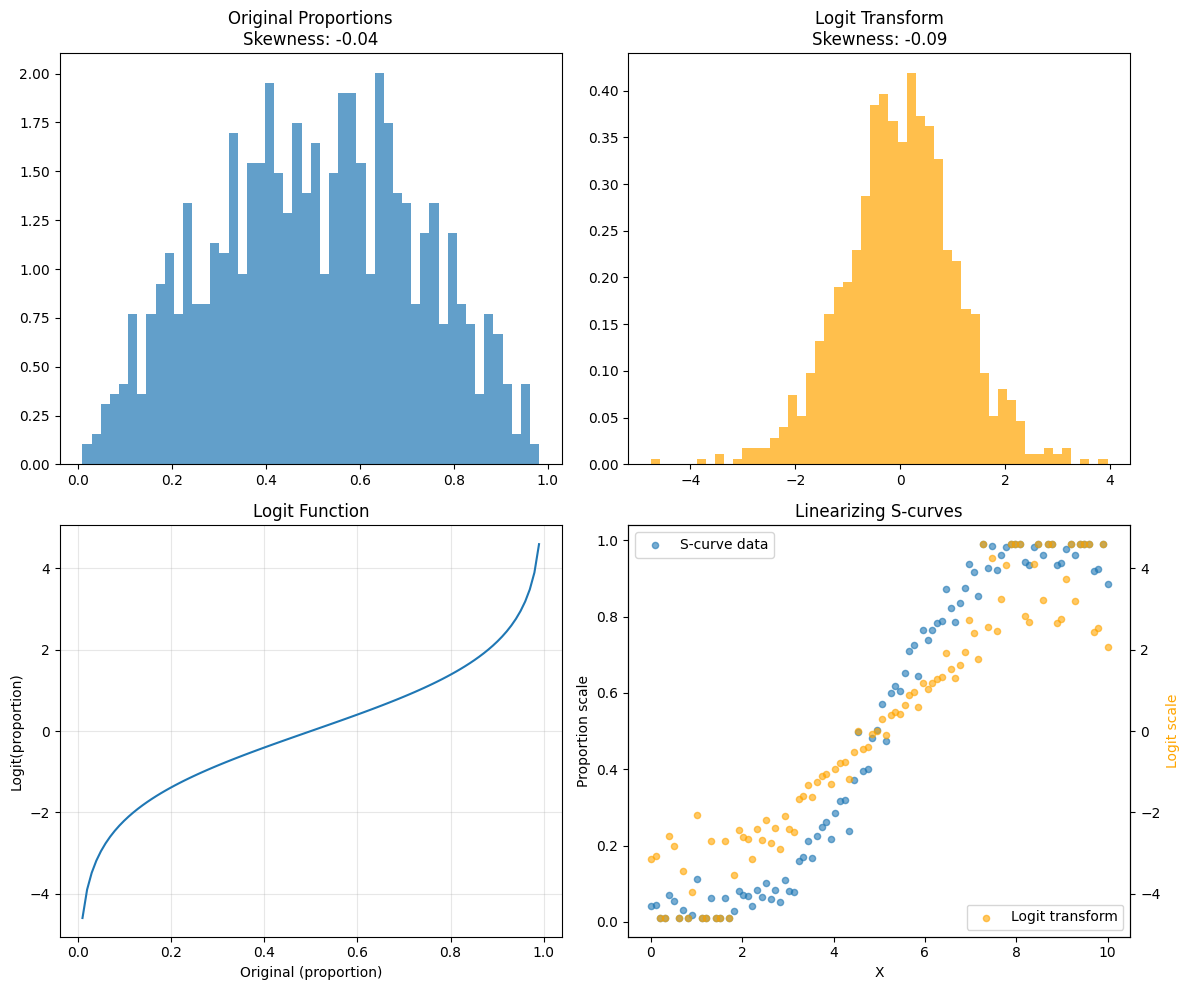

In [6]:
def logit_transformation():
    """Demonstrate logit transformation"""
    # Generate proportion data (avoiding 0 and 1)
    np.random.seed(42)
    proportions = np.random.beta(a=2, b=2, size=1000)
    proportions = np.clip(proportions, 0.001, 0.999)  # Avoid boundaries
    
    # Apply logit transformation
    logit_data = np.log(proportions / (1 - proportions))
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original
    axes[0,0].hist(proportions, bins=50, alpha=0.7, density=True)
    axes[0,0].set_title(f'Original Proportions\nSkewness: {stats.skew(proportions):.2f}')
    
    # Logit transformed
    axes[0,1].hist(logit_data, bins=50, alpha=0.7, density=True, color='orange')
    axes[0,1].set_title(f'Logit Transform\nSkewness: {stats.skew(logit_data):.2f}')
    
    # Transformation function
    x_range = np.linspace(0.01, 0.99, 100)
    y_logit = np.log(x_range / (1 - x_range))
    axes[1,0].plot(x_range, y_logit)
    axes[1,0].set_xlabel('Original (proportion)')
    axes[1,0].set_ylabel('Logit(proportion)')
    axes[1,0].set_title('Logit Function')
    axes[1,0].grid(True, alpha=0.3)
    
    # S-curve linearization example
    x = np.linspace(0, 10, 100)
    y_sigmoid = 1 / (1 + np.exp(-x + 5))  # Sigmoid curve
    y_sigmoid_noisy = y_sigmoid + np.random.normal(0, 0.05, len(y_sigmoid))
    y_sigmoid_noisy = np.clip(y_sigmoid_noisy, 0.01, 0.99)
    
    axes[1,1].scatter(x, y_sigmoid_noisy, alpha=0.6, s=20, label='S-curve data')
    
    # After logit transformation, should be linear
    y_logit_linear = np.log(y_sigmoid_noisy / (1 - y_sigmoid_noisy))
    ax_twin = axes[1,1].twinx()
    ax_twin.scatter(x, y_logit_linear, alpha=0.6, s=20, color='orange', label='Logit transform')
    ax_twin.set_ylabel('Logit scale', color='orange')
    
    axes[1,1].set_xlabel('X')
    axes[1,1].set_ylabel('Proportion scale')
    axes[1,1].set_title('Linearizing S-curves')
    axes[1,1].legend(loc='upper left')
    ax_twin.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

logit_transformation()

---

## 🎨 Transformation Selection Strategy

### The Decision Framework

```pseudocode
FUNCTION choose_transformation(data):
    # Step 1: Analyze data characteristics
    has_negatives = ANY(data < 0)
    has_zeros = ANY(data == 0)
    is_proportion = ALL(data >= 0) AND ALL(data <= 1)
    skewness = COMPUTE_SKEWNESS(data)
    
    # Step 2: Check for specific data types
    IF is_proportion:
        IF max(data) - min(data) > 0.8:  # Wide range
            RETURN "logit"
        ELSE:
            RETURN "arcsin"
    
    # Step 3: Handle negative values
    IF has_negatives:
        RETURN "yeo_johnson"
    
    # Step 4: Handle positive data
    IF has_zeros:
        RETURN "yeo_johnson"  # Safer than Box-Cox
    
    # Step 5: Choose based on skewness
    IF ABS(skewness) < 0.5:
        RETURN "none"  # Already roughly normal
    ELSE IF skewness > 2:
        IF all(data > 0):
            RETURN "box_cox"
        ELSE:
            RETURN "yeo_johnson"
    ELSE:
        RETURN "sqrt"  # Mild transformation
```

### Automated Selection Implementation

Data analysis:
  Range: [0.010, 9.914]
  Skewness: 1.441
  Has negatives: False
  Has zeros: False
  Is proportion: False
  Selected transformation: sqrt
Data analysis:
  Range: [-2.884, 8.172]
  Skewness: 1.693
  Has negatives: True
  Has zeros: False
  Is proportion: False
  Selected transformation: yeo_johnson
Data analysis:
  Range: [0.001, 0.792]
  Skewness: 0.984
  Has negatives: False
  Has zeros: False
  Is proportion: True
  Selected transformation: arcsin
Data analysis:
  Range: [0.432, 0.560]
  Skewness: 0.053
  Has negatives: False
  Has zeros: False
  Is proportion: True
  Selected transformation: arcsin
Data analysis:
  Range: [1.992, 8.152]
  Skewness: -0.100
  Has negatives: False
  Has zeros: False
  Is proportion: False
  Selected transformation: none


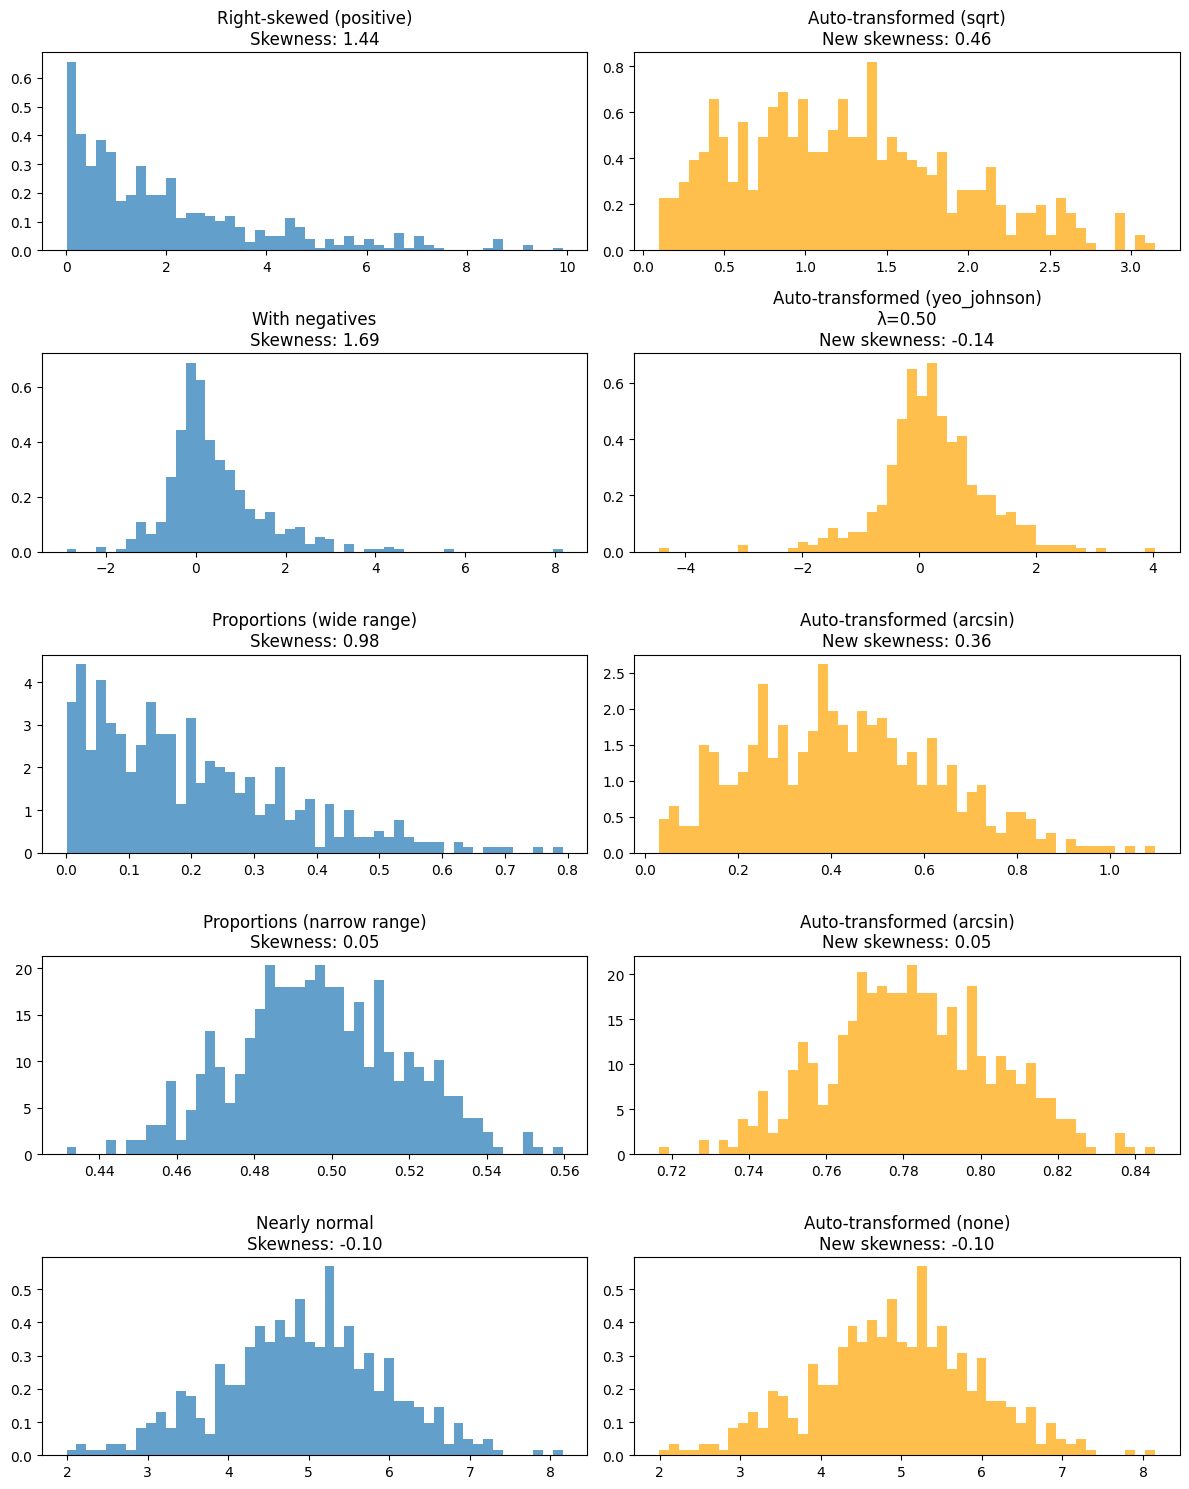

In [7]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import normaltest

class TransformationSelector:
    """Automatically select and apply optimal transformation"""
    
    def __init__(self):
        self.transformation_type = None
        self.transformer = None
        self.lambda_param = None
    
    def fit(self, data):
        """Select optimal transformation based on data characteristics"""
        data = np.array(data).flatten()
        
        # Remove NaN values for analysis
        clean_data = data[~np.isnan(data)]
        
        if len(clean_data) == 0:
            self.transformation_type = 'none'
            return self
        
        # Analyze data characteristics
        has_negatives = np.any(clean_data < 0)
        has_zeros = np.any(clean_data == 0)
        is_proportion = np.all(clean_data >= 0) & np.all(clean_data <= 1)
        skewness = stats.skew(clean_data)
        
        print(f"Data analysis:")
        print(f"  Range: [{np.min(clean_data):.3f}, {np.max(clean_data):.3f}]")
        print(f"  Skewness: {skewness:.3f}")
        print(f"  Has negatives: {has_negatives}")
        print(f"  Has zeros: {has_zeros}")
        print(f"  Is proportion: {is_proportion}")
        
        # Decision logic
        if is_proportion:
            if np.max(clean_data) - np.min(clean_data) > 0.8:
                self.transformation_type = 'logit'
                # Avoid exact 0 and 1
                clean_data = np.clip(clean_data, 0.001, 0.999)
            else:
                self.transformation_type = 'arcsin'
        elif has_negatives or has_zeros:
            self.transformation_type = 'yeo_johnson'
        elif abs(skewness) < 0.5:
            self.transformation_type = 'none'
        elif abs(skewness) > 2 and np.all(clean_data > 0):
            self.transformation_type = 'box_cox'
        else:
            self.transformation_type = 'sqrt'
        
        print(f"  Selected transformation: {self.transformation_type}")
        
        # Fit the selected transformation
        if self.transformation_type == 'box_cox':
            self.transformer = PowerTransformer(method='box-cox', standardize=False)
            self.transformer.fit(clean_data.reshape(-1, 1))
            self.lambda_param = self.transformer.lambdas_[0]
        elif self.transformation_type == 'yeo_johnson':
            self.transformer = PowerTransformer(method='yeo-johnson', standardize=False)
            self.transformer.fit(clean_data.reshape(-1, 1))
            self.lambda_param = self.transformer.lambdas_[0]
        
        return self
    
    def transform(self, data):
        """Apply the selected transformation"""
        data = np.array(data).flatten()
        
        if self.transformation_type == 'none':
            return data
        elif self.transformation_type == 'sqrt':
            return np.sqrt(np.maximum(data, 0))  # Handle any negatives
        elif self.transformation_type == 'logit':
            data_clipped = np.clip(data, 0.001, 0.999)
            return np.log(data_clipped / (1 - data_clipped))
        elif self.transformation_type == 'arcsin':
            return np.arcsin(np.sqrt(np.clip(data, 0, 1)))
        elif self.transformation_type in ['box_cox', 'yeo_johnson']:
            return self.transformer.transform(data.reshape(-1, 1)).flatten()
        
        return data
    
    def fit_transform(self, data):
        """Fit and transform in one step"""
        return self.fit(data).transform(data)

# Demonstration
def automated_selection_demo():
    """Demonstrate automated transformation selection"""
    # Create different types of problematic data
    np.random.seed(42)
    
    datasets = {
        'Right-skewed (positive)': np.random.exponential(scale=2, size=500),
        'With negatives': np.concatenate([
            np.random.exponential(scale=1, size=300),
            -np.random.exponential(scale=0.5, size=200)
        ]),
        'Proportions (wide range)': np.random.beta(a=1, b=4, size=500),
        'Proportions (narrow range)': np.random.beta(a=10, b=10, size=500) * 0.2 + 0.4,
        'Nearly normal': np.random.normal(loc=5, scale=1, size=500)
    }
    
    fig, axes = plt.subplots(len(datasets), 2, figsize=(12, 15))
    
    for idx, (name, data) in enumerate(datasets.items()):
        # Original data
        axes[idx, 0].hist(data, bins=50, alpha=0.7, density=True)
        axes[idx, 0].set_title(f'{name}\nSkewness: {stats.skew(data):.2f}')
        
        # Apply automatic transformation
        selector = TransformationSelector()
        transformed_data = selector.fit_transform(data)
        
        # Transformed data
        axes[idx, 1].hist(transformed_data, bins=50, alpha=0.7, 
                         density=True, color='orange')
        title = f'Auto-transformed ({selector.transformation_type})'
        if selector.lambda_param is not None:
            title += f'\nλ={selector.lambda_param:.2f}'
        title += f'\nNew skewness: {stats.skew(transformed_data):.2f}'
        axes[idx, 1].set_title(title)
    
    plt.tight_layout()
    plt.show()

automated_selection_demo()

---

## 📊 Evaluation and Validation

### Assessing Transformation Quality

#### 1. Statistical Tests

**Shapiro-Wilk Test** for normality:
$H_0: \text{Data comes from normal distribution}$
$W = \frac{(\sum_{i=1}^n a_i x_{(i)})^2}{\sum_{i=1}^n (x_i - \bar{x})^2}$

**Anderson-Darling Test** (more sensitive to tails):
$A^2 = -n - \frac{1}{n}\sum_{i=1}^n (2i-1)[\ln F(x_i) + \ln(1-F(x_{n+1-i}))]$

**Jarque-Bera Test** (based on skewness and kurtosis):
$JB = \frac{n}{6}\left(S^2 + \frac{(K-3)^2}{4}\right)$

Transformation Quality Assessment:
  Transformation  Skewness  Kurtosis  Shapiro p-value  Anderson-Darling  \
0       Original    9.5122  134.0618           0.0000           66.5547   
1            Log    0.1796    0.2564           0.4013            0.2978   
2    Square Root    2.6698   15.0415           0.0000           16.2717   
3        Box-Cox   -0.0031    0.1654           0.9382            0.2031   

   Jarque-Bera p-value  
0               0.0000  
1               0.1315  
2               0.0000  
3               0.7516  


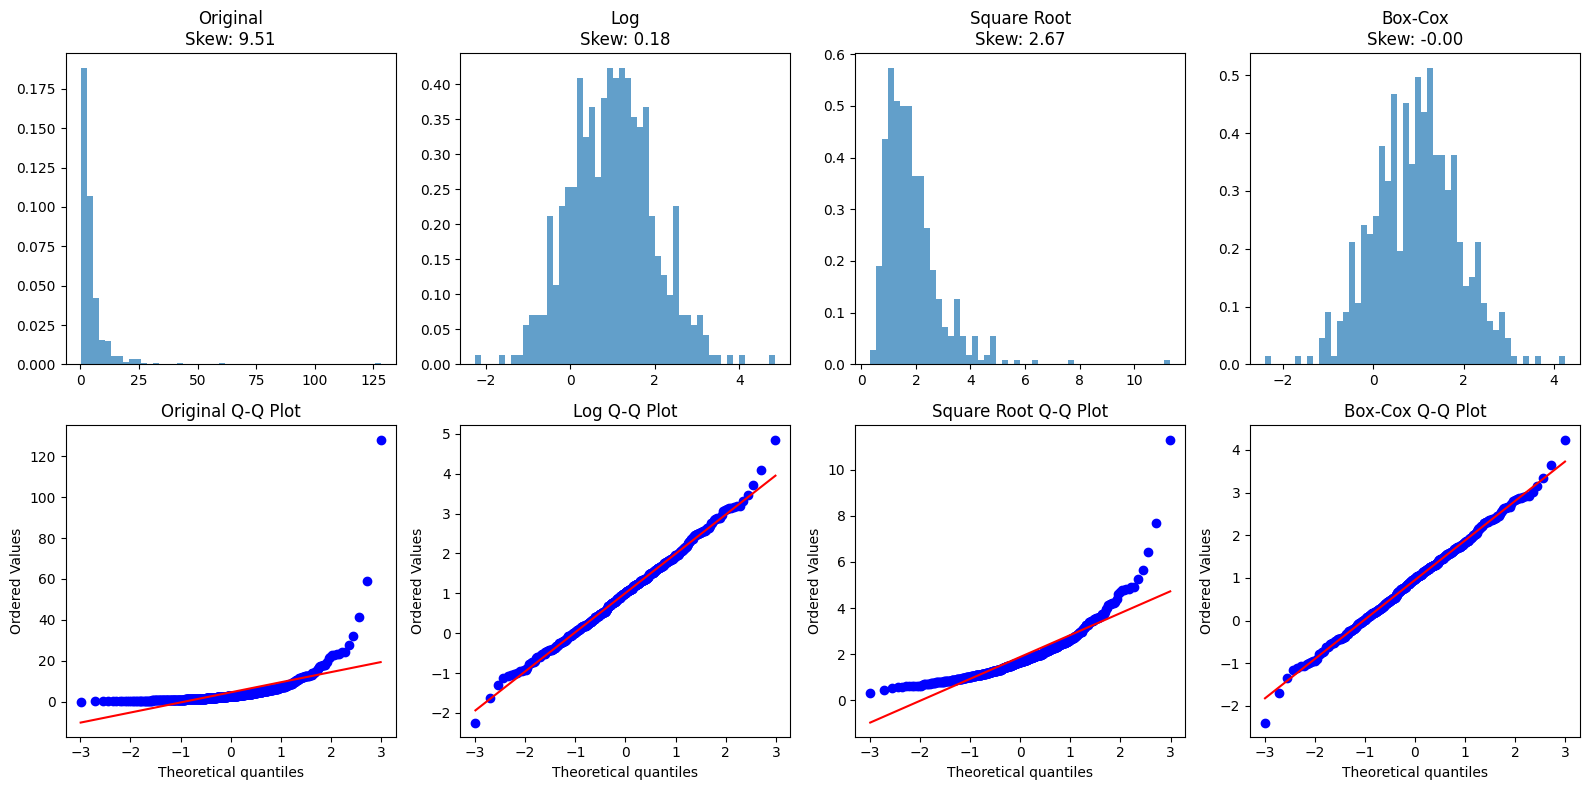

,Transformation,Skewness,Kurtosis,Shapiro p-value,Anderson-Darling,Jarque-Bera p-value
0,Original,9.512240,134.061781,2.577079e-37,66.554673,0.000000
1,Log,0.179623,0.256381,4.012691e-01,0.297780,0.131460
2,Square Root,2.669802,15.041462,1.673941e-23,16.271660,0.000000
3,Box-Cox,-0.003113,0.165440,9.382335e-01,0.203104,0.751629


In [8]:
from scipy.stats import shapiro, anderson, jarque_bera

def evaluate_transformation_quality():
    """Comprehensive evaluation of transformation quality"""
    
    # Generate test data
    np.random.seed(42)
    original_data = np.random.lognormal(mean=1, sigma=1, size=500)
    
    # Apply different transformations
    transformations = {
        'Original': original_data,
        'Log': np.log(original_data),
        'Square Root': np.sqrt(original_data),
        'Box-Cox': None  # Will be computed
    }
    
    # Box-Cox transformation
    transformed_boxcox, lambda_bc = boxcox(original_data)
    transformations['Box-Cox'] = transformed_boxcox
    
    # Evaluation metrics
    results = []
    
    for name, data in transformations.items():
        # Statistical tests
        shapiro_stat, shapiro_p = shapiro(data)
        ad_stat, ad_critical, ad_significance = anderson(data, dist='norm')
        jb_stat, jb_p = jarque_bera(data)
        
        # Descriptive statistics
        skewness = stats.skew(data)
        kurtosis = stats.kurtosis(data)
        
        results.append({
            'Transformation': name,
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'Shapiro p-value': shapiro_p,
            'Anderson-Darling': ad_stat,
            'Jarque-Bera p-value': jb_p
        })
    
    # Create results table
    import pandas as pd
    results_df = pd.DataFrame(results)
    print("Transformation Quality Assessment:")
    print("=" * 50)
    print(results_df.round(4))
    
    # Visualization
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for idx, (name, data) in enumerate(transformations.items()):
        # Histogram
        axes[0, idx].hist(data, bins=50, alpha=0.7, density=True)
        axes[0, idx].set_title(f'{name}\nSkew: {stats.skew(data):.2f}')
        
        # Q-Q plot
        stats.probplot(data, dist="norm", plot=axes[1, idx])
        axes[1, idx].set_title(f'{name} Q-Q Plot')
    
    plt.tight_layout()
    plt.show()
    
    return results_df

evaluate_transformation_quality()

#### 2. Visual Diagnostics

**Q-Q Plots**: Compare quantiles against theoretical normal distribution.

**P-P Plots**: Compare cumulative probabilities.

**Histogram + Normal Overlay**: Visual normality check.

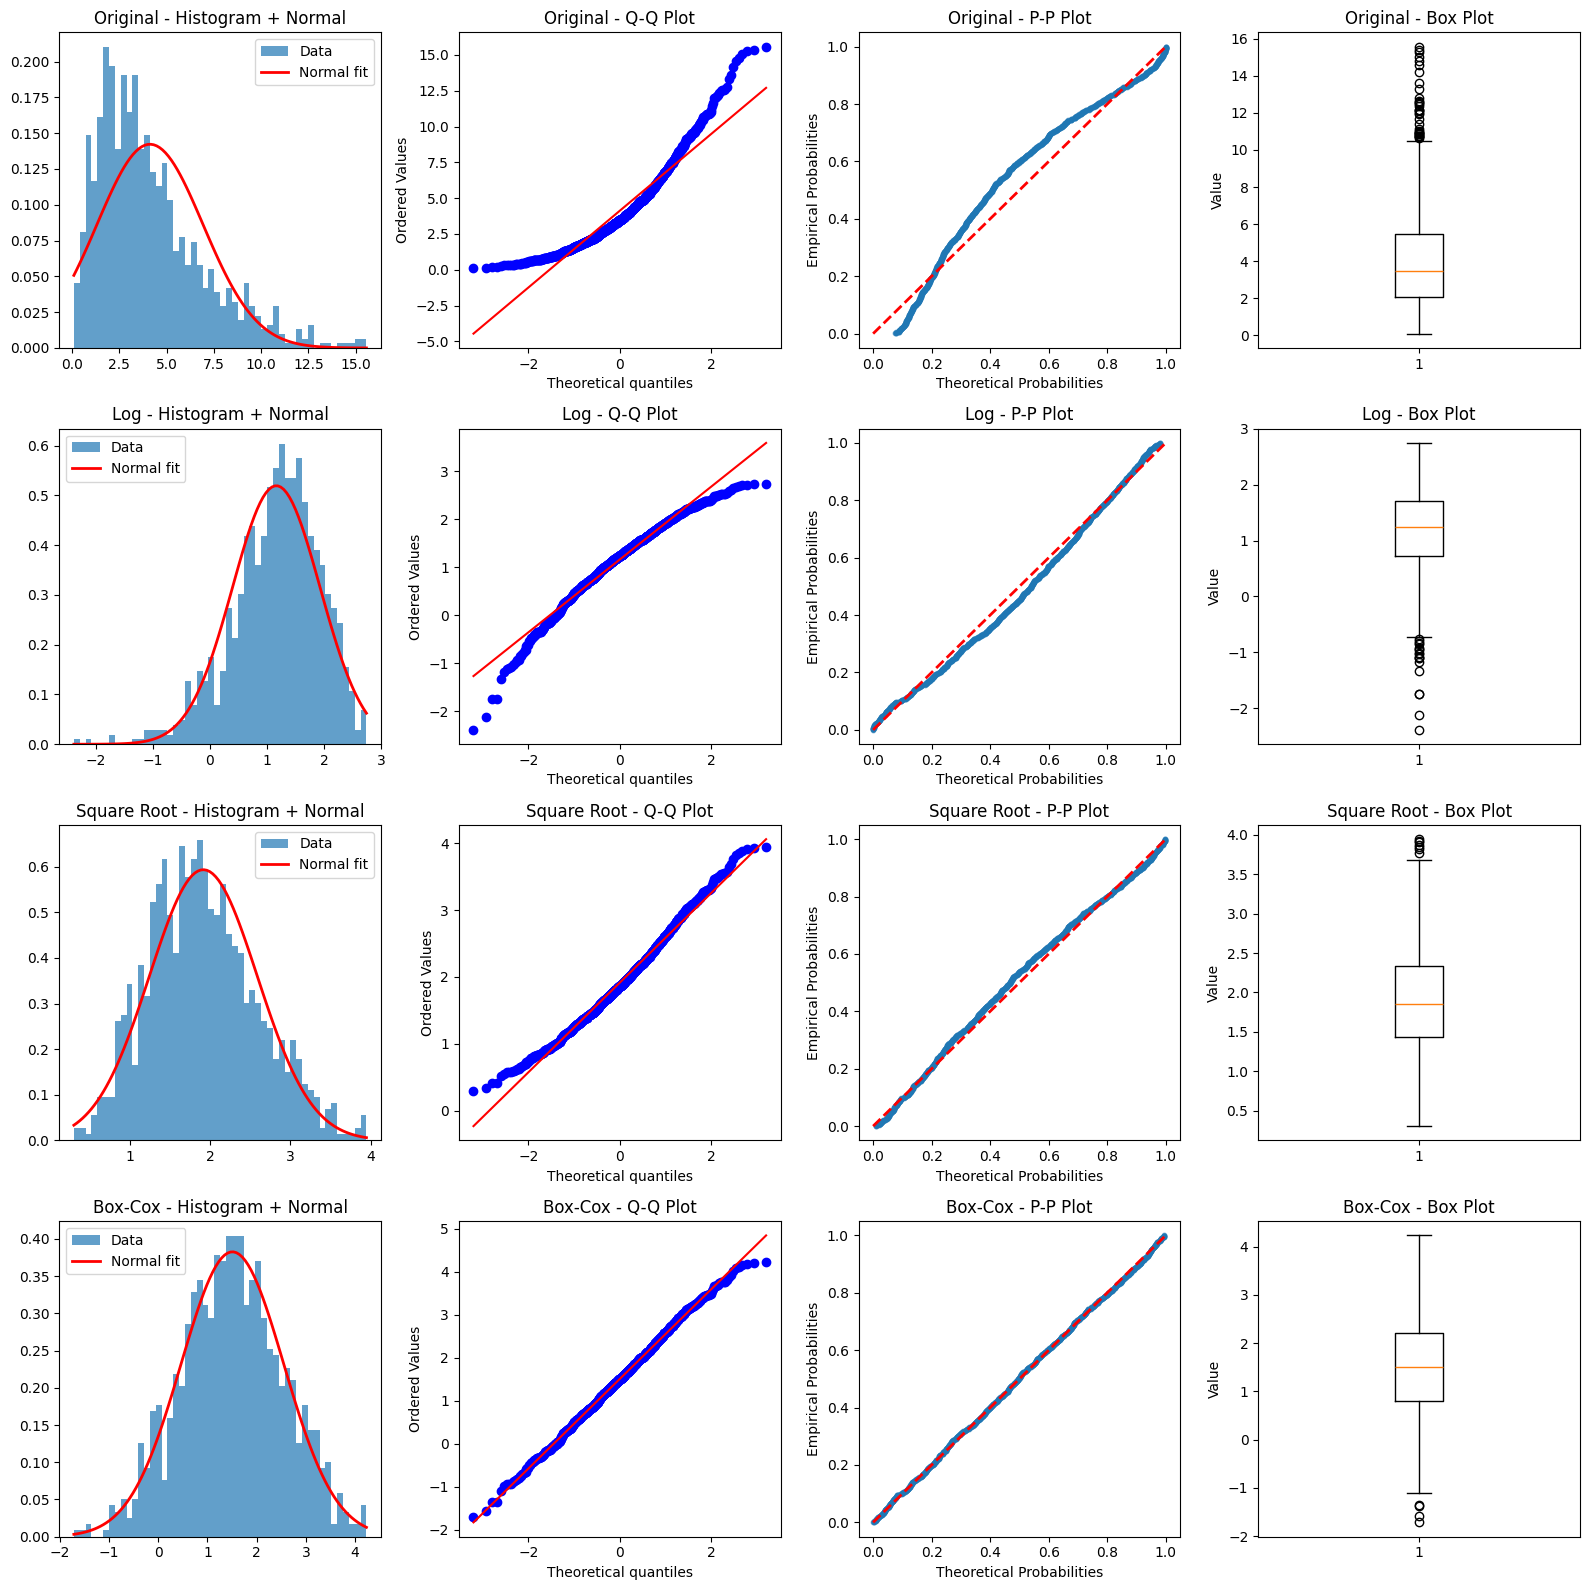

In [9]:
def comprehensive_visual_diagnostics():
    """Create comprehensive visual diagnostics for transformations"""
    
    # Generate problematic data
    np.random.seed(42)
    data = np.random.gamma(shape=2, scale=2, size=1000)
    
    # Apply transformations
    log_data = np.log(data)
    sqrt_data = np.sqrt(data)
    boxcox_data, lambda_opt = boxcox(data)
    
    transformations = [
        ('Original', data),
        ('Log', log_data),
        ('Square Root', sqrt_data),
        ('Box-Cox', boxcox_data)
    ]
    
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    
    for i, (name, transformed_data) in enumerate(transformations):
        # Histogram with normal overlay
        axes[i, 0].hist(transformed_data, bins=50, alpha=0.7, density=True, 
                       label='Data')
        
        # Fit normal distribution and overlay
        mu, sigma = stats.norm.fit(transformed_data)
        x_norm = np.linspace(transformed_data.min(), transformed_data.max(), 100)
        y_norm = stats.norm.pdf(x_norm, mu, sigma)
        axes[i, 0].plot(x_norm, y_norm, 'r-', linewidth=2, label='Normal fit')
        axes[i, 0].set_title(f'{name} - Histogram + Normal')
        axes[i, 0].legend()
        
        # Q-Q plot
        stats.probplot(transformed_data, dist="norm", plot=axes[i, 1])
        axes[i, 1].set_title(f'{name} - Q-Q Plot')
        
        # P-P plot
        sorted_data = np.sort(transformed_data)
        theoretical_probs = stats.norm.cdf(sorted_data, mu, sigma)
        empirical_probs = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        
        axes[i, 2].scatter(theoretical_probs, empirical_probs, alpha=0.6, s=10)
        axes[i, 2].plot([0, 1], [0, 1], 'r--', linewidth=2)
        axes[i, 2].set_xlabel('Theoretical Probabilities')
        axes[i, 2].set_ylabel('Empirical Probabilities')
        axes[i, 2].set_title(f'{name} - P-P Plot')
        
        # Box plot
        axes[i, 3].boxplot(transformed_data)
        axes[i, 3].set_title(f'{name} - Box Plot')
        axes[i, 3].set_ylabel('Value')
    
    plt.tight_layout()
    plt.show()

comprehensive_visual_diagnostics()

#### 3. Cross-Validation for Transformation Selection

Cross-Validation Results for Transformations:
             CV Score (MSE)  CV Std      R²
None                 2.8530  0.3294  0.6219
Log                  0.2544  0.0247  0.9663
Square Root          1.2945  0.1440  0.8282
Box-Cox              0.6417  0.0738  0.9148


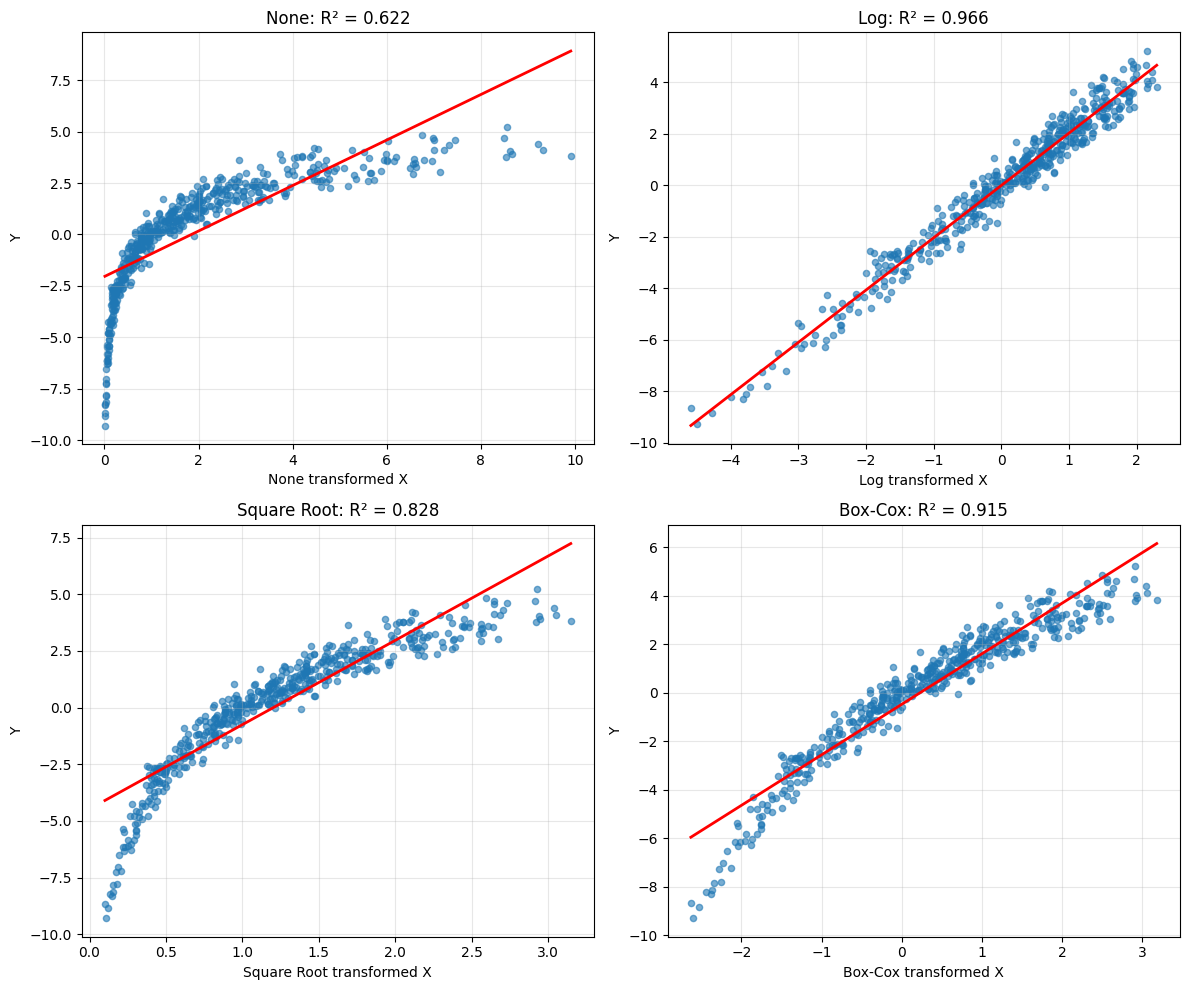

,CV Score (MSE),CV Std,R²
None,2.853034,0.329397,0.621854
Log,0.254363,0.024697,0.966255
Square Root,1.294459,0.144011,0.828167
Box-Cox,0.641741,0.073767,0.914769


In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def cross_validate_transformations():
    """Use cross-validation to select best transformation for prediction"""
    
    # Generate data with known relationship
    np.random.seed(42)
    x = np.random.exponential(scale=2, size=500)
    # True relationship: y depends on log(x)
    y = 2 * np.log(x) + np.random.normal(0, 0.5, len(x))
    
    # Test different transformations of x
    transformations = {
        'None': x,
        'Log': np.log(x),
        'Square Root': np.sqrt(x),
        'Box-Cox': boxcox(x)[0]
    }
    
    results = {}
    
    for name, x_transformed in transformations.items():
        # Reshape for sklearn
        X = x_transformed.reshape(-1, 1)
        
        # Cross-validation
        lr = LinearRegression()
        cv_scores = cross_val_score(lr, X, y, cv=5, 
                                   scoring='neg_mean_squared_error')
        
        results[name] = {
            'CV Score (MSE)': -cv_scores.mean(),
            'CV Std': cv_scores.std(),
            'R²': lr.fit(X, y).score(X, y)
        }
    
    # Results table
    import pandas as pd
    results_df = pd.DataFrame(results).T
    print("Cross-Validation Results for Transformations:")
    print("=" * 50)
    print(results_df.round(4))
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, (name, x_transformed) in enumerate(transformations.items()):
        axes[i].scatter(x_transformed, y, alpha=0.6, s=20)
        
        # Fit line
        X = x_transformed.reshape(-1, 1)
        lr = LinearRegression().fit(X, y)
        x_line = np.linspace(x_transformed.min(), x_transformed.max(), 100)
        y_line = lr.predict(x_line.reshape(-1, 1))
        axes[i].plot(x_line, y_line, 'r-', linewidth=2)
        
        axes[i].set_xlabel(f'{name} transformed X')
        axes[i].set_ylabel('Y')
        axes[i].set_title(f'{name}: R² = {results[name]["R²"]:.3f}')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df

cross_validate_transformations()

---

## 🎯 Advanced Topics

### 1. Multivariate Transformations

When dealing with multiple variables, we need coordinated transformations:

#### Independent Transformation
```pseudocode
FOR each variable X_i:
    optimal_lambda_i = FIND_OPTIMAL_LAMBDA(X_i)
    X_i_transformed = APPLY_TRANSFORMATION(X_i, optimal_lambda_i)
```

#### Simultaneous Optimization
```pseudocode
FUNCTION multivariate_boxcox(X_matrix):
    # Optimize all lambdas jointly
    OBJECTIVE = MULTIVARIATE_NORMAL_LIKELIHOOD(transformed_X)
    
    lambda_vector = OPTIMIZE(OBJECTIVE, initial_lambdas)
    
    FOR i = 1 to n_variables:
        X_i_transformed = BOXCOX(X_i, lambda_vector[i])
    
    RETURN transformed_matrix
```

Original correlation: 0.675
After independent log transform: 0.673


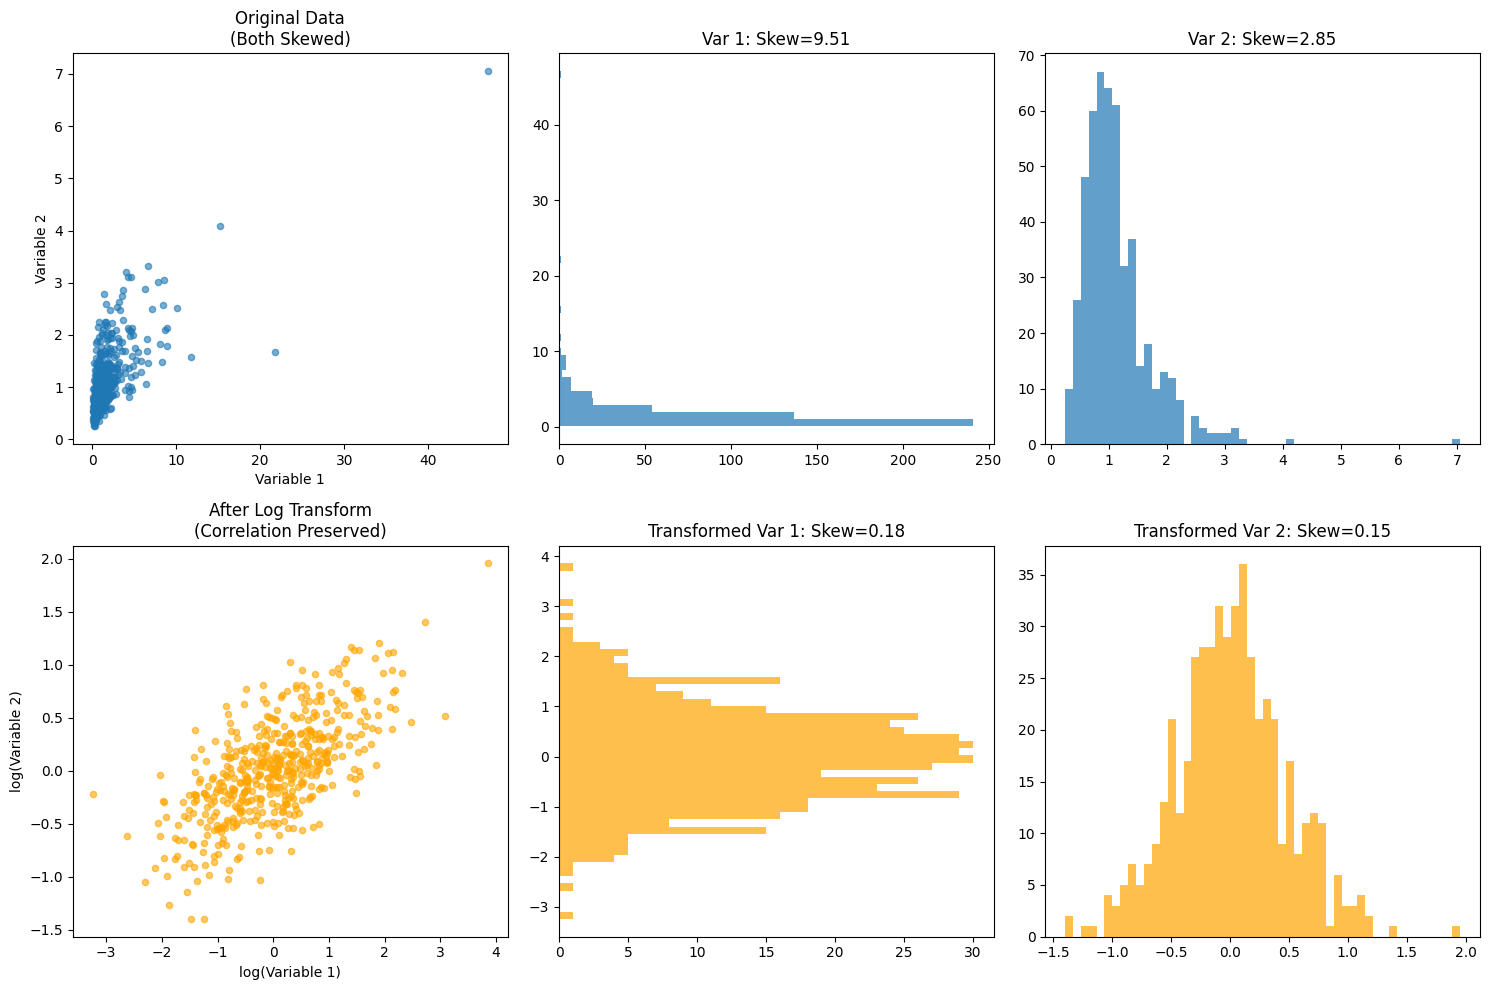

In [11]:
def multivariate_transformation_demo():
    """Demonstrate multivariate transformation challenges"""
    
    # Generate correlated skewed data
    np.random.seed(42)
    n = 500
    
    # Base normal variables
    z1 = np.random.normal(0, 1, n)
    z2 = np.random.normal(0, 1, n)
    
    # Create correlation
    x1 = z1
    x2 = 0.7 * z1 + 0.714 * z2  # Correlation ≈ 0.7
    
    # Transform to create skewness
    data1 = np.exp(x1)  # Lognormal
    data2 = np.exp(0.5 * x2)  # Less skewed lognormal
    
    print(f"Original correlation: {np.corrcoef(data1, data2)[0,1]:.3f}")
    
    # Independent transformations
    trans1_indep = np.log(data1)
    trans2_indep = np.log(data2)
    
    print(f"After independent log transform: {np.corrcoef(trans1_indep, trans2_indep)[0,1]:.3f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original data
    axes[0,0].scatter(data1, data2, alpha=0.6, s=20)
    axes[0,0].set_title('Original Data\n(Both Skewed)')
    axes[0,0].set_xlabel('Variable 1')
    axes[0,0].set_ylabel('Variable 2')
    
    # Marginal distributions
    axes[0,1].hist(data1, bins=50, alpha=0.7, orientation='horizontal')
    axes[0,1].set_title(f'Var 1: Skew={stats.skew(data1):.2f}')
    
    axes[0,2].hist(data2, bins=50, alpha=0.7)
    axes[0,2].set_title(f'Var 2: Skew={stats.skew(data2):.2f}')
    
    # After transformation
    axes[1,0].scatter(trans1_indep, trans2_indep, alpha=0.6, s=20, color='orange')
    axes[1,0].set_title('After Log Transform\n(Correlation Preserved)')
    axes[1,0].set_xlabel('log(Variable 1)')
    axes[1,0].set_ylabel('log(Variable 2)')
    
    axes[1,1].hist(trans1_indep, bins=50, alpha=0.7, orientation='horizontal', color='orange')
    axes[1,1].set_title(f'Transformed Var 1: Skew={stats.skew(trans1_indep):.2f}')
    
    axes[1,2].hist(trans2_indep, bins=50, alpha=0.7, color='orange')
    axes[1,2].set_title(f'Transformed Var 2: Skew={stats.skew(trans2_indep):.2f}')
    
    plt.tight_layout()
    plt.show()

multivariate_transformation_demo()

### 2. Inverse Transformations

Always important to be able to transform back to original scale:

In [12]:
class InvertibleTransformer:
    """Transformer that can invert transformations"""
    
    def __init__(self, method='auto'):
        self.method = method
        self.fitted_lambda = None
        self.transformation_type = None
        self.original_mean = None
        self.original_std = None
    
    def fit(self, data):
        """Fit transformation and store parameters"""
        if self.method == 'box_cox':
            self.fitted_data, self.fitted_lambda = boxcox(data)
            self.transformation_type = 'box_cox'
        elif self.method == 'log':
            self.fitted_data = np.log(data)
            self.transformation_type = 'log'
        # ... other methods
        
        return self
    
    def transform(self, data):
        """Apply transformation"""
        if self.transformation_type == 'box_cox':
            if self.fitted_lambda != 0:
                return (data ** self.fitted_lambda - 1) / self.fitted_lambda
            else:
                return np.log(data)
        elif self.transformation_type == 'log':
            return np.log(data)
        # ... other methods
    
    def inverse_transform(self, transformed_data):
        """Convert back to original scale"""
        if self.transformation_type == 'box_cox':
            if self.fitted_lambda != 0:
                return (self.fitted_lambda * transformed_data + 1) ** (1/self.fitted_lambda)
            else:
                return np.exp(transformed_data)
        elif self.transformation_type == 'log':
            return np.exp(transformed_data)
        # ... other methods

def demonstrate_inverse_transformation():
    """Show importance of inverse transformations"""
    
    # Original data
    np.random.seed(42)
    original = np.random.lognormal(mean=1, sigma=0.5, size=100)
    
    # Transform
    transformer = InvertibleTransformer(method='log')
    transformer.fit(original)
    transformed = transformer.transform(original)
    
    # Inverse transform
    recovered = transformer.inverse_transform(transformed)
    
    # Check recovery
    print(f"Original mean: {np.mean(original):.4f}")
    print(f"Recovered mean: {np.mean(recovered):.4f}")
    print(f"Max difference: {np.max(np.abs(original - recovered)):.10f}")
    
    # Practical example: model predictions
    # Fit model on transformed data
    from sklearn.linear_model import LinearRegression
    
    # Create some X variable
    X = np.random.normal(0, 1, len(original)).reshape(-1, 1)
    
    # Fit model
    model = LinearRegression()
    model.fit(X, transformed)
    
    # Predict on new data
    X_new = np.array([[0.5], [1.0], [1.5]])
    predictions_transformed = model.predict(X_new)
    
    # Convert predictions back to original scale
    predictions_original_scale = transformer.inverse_transform(predictions_transformed)
    
    print(f"\nPredictions on transformed scale: {predictions_transformed}")
    print(f"Predictions on original scale: {predictions_original_scale}")

demonstrate_inverse_transformation()

Original mean: 2.8496
Recovered mean: 2.8496
Max difference: 0.0000000000

Predictions on transformed scale: [0.91704723 0.88456889 0.85209055]
Predictions on original scale: [2.50189197 2.42194004 2.34454311]


---

## 📝 Best Practices and Guidelines

### 1. The Transformation Workflow

```pseudocode
TRANSFORMATION_WORKFLOW:
    1. EXPLORE_DATA()
       - Plot histograms
       - Check skewness, kurtosis
       - Identify outliers
       - Check for zeros/negatives
    
    2. SELECT_CANDIDATE_TRANSFORMATIONS()
       - Based on data characteristics
       - Consider domain knowledge
       - Include "no transformation" as baseline
    
    3. APPLY_AND_EVALUATE()
       - Statistical tests (Shapiro-Wilk, etc.)
       - Visual diagnostics (Q-Q plots)
       - Cross-validation if prediction is goal
    
    4. VALIDATE_CHOICE()
       - Check assumptions of downstream analysis
       - Ensure interpretability is maintained
       - Document transformation for reproducibility
    
    5. IMPLEMENT_WITH_INVERSE()
       - Always keep ability to transform back
       - Important for interpretation and reporting
```

### 2. Common Pitfalls to Avoid

**❌ Mistake 1**: Transforming without understanding why

In [13]:
# Bad: Automatic without thought
transformed = np.log(data)  # Why log? Does it make sense?

# Good: Motivated transformation
if stats.skew(data) > 1 and np.all(data > 0):
    transformed = np.log(data)  # Reduce right skew

NameError: name 'data' is not defined

**❌ Mistake 2**: Ignoring domain knowledge

In [ ]:
# Bad: Purely statistical decision
best_lambda = find_optimal_lambda(prices)

# Good: Consider domain meaning
# Log transformation of prices makes economic sense
# (multiplicative effects, percentage changes)
if data_represents_prices:
    transformed = np.log(prices)

**❌ Mistake 3**: Not validating on test data

In [ ]:
# Bad: Choose transformation based on same data used for modeling
transform_params = fit_transformation(train_data)
model.fit(transform(train_data))

# Good: Validate transformation choice separately
transform_params = fit_transformation(validation_data)

### 3. Documentation and Reproducibility

In [ ]:
class DocumentedTransformer:
    """Transformer with comprehensive documentation"""
    
    def __init__(self):
        self.transformation_log = []
    
    def fit_transform(self, data, method='auto'):
        # Document original data characteristics
        log_entry = {
            'timestamp': datetime.now(),
            'original_shape': data.shape,
            'original_range': (np.min(data), np.max(data)),
            'original_skewness': stats.skew(data),
            'original_kurtosis': stats.kurtosis(data),
            'method_selected': method,
            'reasons': []
        }
        
        # Selection logic with documentation
        if method == 'auto':
            if np.any(data <= 0):
                method = 'yeo_johnson'
                log_entry['reasons'].append('Contains non-positive values')
            elif stats.skew(data) > 2:
                method = 'box_cox'
                log_entry['reasons'].append(f'High right skew: {stats.skew(data):.2f}')
            # ... more logic
        
        # Apply transformation
        # ... transformation code ...
        
        # Document results
        log_entry.update({
            'final_method': method,
            'parameters': getattr(self, 'fitted_lambda', None),
            'final_skewness': stats.skew(transformed_data),
            'normality_p_value': shapiro(transformed_data)[1]
        })
        
        self.transformation_log.append(log_entry)
        return transformed_data
    
    def print_report(self):
        """Print comprehensive transformation report"""
        for entry in self.transformation_log:
            print(f"Transformation Report - {entry['timestamp']}")
            print(f"Method: {entry['final_method']}")
            print(f"Reasons: {', '.join(entry['reasons'])}")
            print(f"Skewness: {entry['original_skewness']:.3f} → {entry['final_skewness']:.3f}")
            print("-" * 50)

---

## 🎓 Summary and Key Takeaways

### The Big Picture

Data transformation is both **art and science**:
- **Science**: Statistical tests, optimization, mathematical foundations
- **Art**: Domain knowledge, interpretability, practical considerations

### Decision Framework Summary

| Data Characteristic | Recommended Transformation | Mathematical Justification |
|---------------------|---------------------------|----------------------------|
| **Right-skewed, positive** | Log or Box-Cox | Compresses large values |
| **Contains zeros/negatives** | Yeo-Johnson | Handles all real numbers |
| **Proportions (0,1)** | Logit or Arcsin | Variance stabilization |
| **Count data** | Square root | Poisson variance = mean |
| **Already normal** | None | Don't fix what isn't broken |
| **Extreme outliers** | Robust methods first | Address outliers directly |

### Mathematical Insights

1. **Power transformations** create a continuum: $x^{\lambda}$ smoothly transitions from inverse ($\lambda = -1$) through log ($\lambda = 0$) to square ($\lambda = 2$)

2. **Box-Cox optimization** finds the $\lambda$ that maximizes likelihood under normality assumption

3. **Variance stabilization** often more important than normality for many analyses

4. **Jacobian terms** in likelihood ensure proper probability density transformation

### Practical Wisdom

- **Always validate** transformation choice on independent data
- **Document reasons** for transformation decisions
- **Keep inverse capability** for interpretation
- **Consider domain meaning** - statistical optimality isn't everything
- **Start simple** - try sqrt or log before complex methods
- **Multiple validation** - use several diagnostic tools

### Final Advice for Students

> "The best transformation is often the simplest one that achieves your goals. Don't optimize the skewness to 0.001 if sqrt gets you to 0.1 and is easier to interpret!"

Remember: **Transformation is a tool to reveal patterns**, not an end in itself. The goal is insight and valid analysis, not perfect test statistics.